## Imports

In [54]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt

## Data

In [55]:
transform = transforms.ToTensor()

In [56]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [57]:
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=20, shuffle=True)

## Model


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [59]:
class DenisingAutoEncoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.btch_1 = nn.BatchNorm2d(64)
        self.max_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1)
        self.btch_2 = nn.BatchNorm2d(128)
        self.max_2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.bottle_neck = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=1)
        self.btch_bottle = nn.BatchNorm2d(256)

        self.conv_3 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=1, padding=1)
        self.btch_3 = nn.BatchNorm2d(128)
        self.up_sample_1 = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.btch_4 = nn.BatchNorm2d(64)
        self.up_sample_2 = nn.Upsample(scale_factor=2, mode='nearest')

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(3, 3), stride=1, padding=1)


    def forward(self, x):
        x = torch.relu(self.btch_1(self.conv_1(x)))
        x = self.max_1(x)

        x = torch.relu(self.btch_2(self.conv_2(x)))
        x = self.max_2(x)

        x = torch.relu(self.btch_bottle(self.bottle_neck(x)))

        x = torch.relu(self.btch_3(self.conv_3(x)))
        x = self.up_sample_1(x)

        x = torch.relu(self.btch_4(self.conv_4(x)))
        x = self.up_sample_2(x)

        x = torch.sigmoid(self.out(x))

        return x



In [60]:
model = DenisingAutoEncoder().to(device)
model

DenisingAutoEncoder(
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btch_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btch_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottle_neck): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btch_bottle): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btch_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up_sample_1): Upsample(scale_factor=2.0, mode=nearest)
  (conv_4): Conv2d(128, 64, kernel_size=(3

## Train

In [61]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 30
NOISE_FACTOR=0.3

In [62]:
def add_noise(inputs,noise_factor=0.3):
	noisy = inputs + torch.randn_like(inputs) * noise_factor
	noisy = torch.clip(noisy, 0., 1.)
	return noisy

In [63]:
for epoch in range(EPOCHS):

    train_loss = 0

    for images, labels in train_loader:

        images = images.to(device)
        noisy_images = add_noise(images, NOISE_FACTOR)

        preds = model(noisy_images)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            loss = criterion(preds, images)
            loss.backward()
            optimizer.step()

        train_loss += loss

    print(f'Epoch{epoch}: loss={loss}')


Epoch0: loss=0.0047792657278478146
Epoch1: loss=0.00491326255723834
Epoch2: loss=0.004475639201700687
Epoch3: loss=0.004675999283790588
Epoch4: loss=0.004393585026264191
Epoch5: loss=0.003821273799985647
Epoch6: loss=0.0038960068486630917
Epoch7: loss=0.0043729087337851524
Epoch8: loss=0.004397992510348558
Epoch9: loss=0.004908377770334482
Epoch10: loss=0.003559855977073312
Epoch11: loss=0.004554697312414646
Epoch12: loss=0.004243388306349516
Epoch13: loss=0.0043142917566001415
Epoch14: loss=0.0037290873005986214
Epoch15: loss=0.004206500481814146
Epoch16: loss=0.004343463107943535
Epoch17: loss=0.0033401355613023043
Epoch18: loss=0.003976930398494005
Epoch19: loss=0.003911479376256466
Epoch20: loss=0.0038912715390324593
Epoch21: loss=0.0036126330960541964
Epoch22: loss=0.004475550260394812
Epoch23: loss=0.0035595993977040052
Epoch24: loss=0.00404325220733881
Epoch25: loss=0.00404199305921793
Epoch26: loss=0.0037674056366086006
Epoch27: loss=0.003646888304501772
Epoch28: loss=0.0035373

## Results

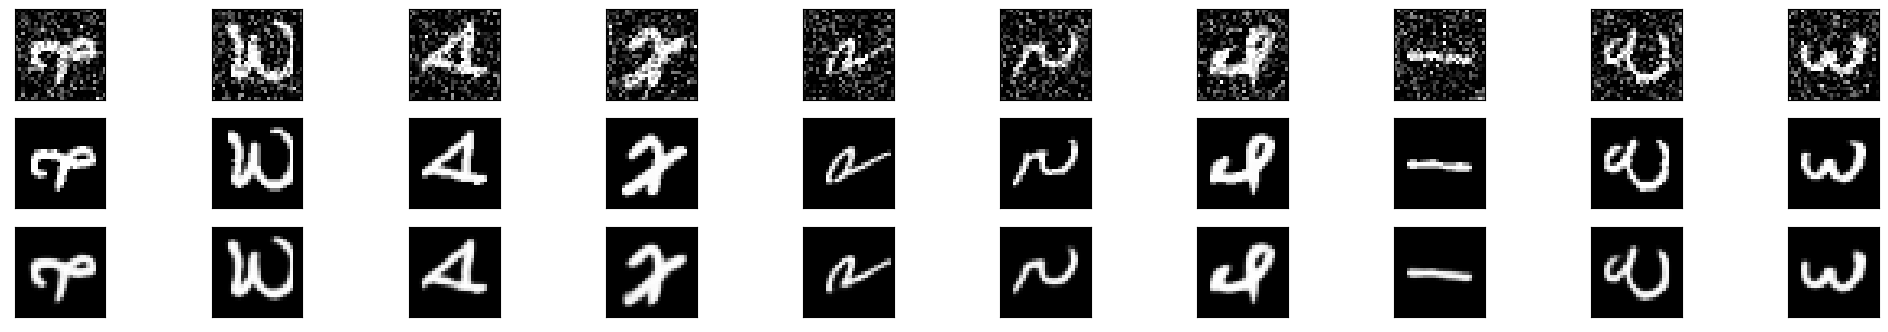

In [66]:
dataiter = iter(test_loader)
images, labels = next(dataiter)



noisy_images = add_noise(images).to(device)

output = model(noisy_images)

mean = output.mean(dim=0)

noisy_images = noisy_images.permute(0, 3, 1, 2)
noisy_images = noisy_images.detach().cpu().numpy()

images = images.permute(0, 3, 1, 2)
images = images.detach().cpu().numpy()

output = output.permute(0, 3, 1, 2)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([noisy_images, images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)